# Attractor municipalities

In this script we select the attractor municipalitites based on the complexity index.

We cluster the data using in one axis the complexity of the X municiaplity and in the other the number of municipalitites that have a complexity index at 1/2 standard deviations from the complexity index of the X municipality.

We make 7 clusters and select the municipalities that fall in the last part of the distribution.

The output of this script is a csv file with the attractors.

In [61]:
import pandas as pd
import geopandas as gpd
import numpy as np
import math

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from shapely.geometry import Polygon
from sklearn.cluster import DBSCAN

# Paths and names

In [11]:
# We define the paths and names for the input files

entities_path = 'marco_geoestadistico_2018/'

# complexity_path = 'ECI_2014__municipal_A111A_H001A_6.csv'

# We define the paths and names for the output files

In [3]:
# We define a dictionary to read the shape files
entities= {
    '01' :['01Ags','01_aguascalientes'],
    '02' :['02BC','02_bajacalifornia'],
    '03' :['03BCS','03_bajacaliforniasur'],
    '04' :['04Camp', '04_campeche'],
    '05' :['05Coah','05_coahuiladezaragoza'],
    '06' :['06Col','06_colima'],
    '07' :[ '07Chs','07_chiapas'],
    '08' :['08Chih','08_chihuahua'],
    '09' :['09CdMx','09_ciudaddemexico'],
    '10' :['10Dur','10_durango'],
    '11' :['11Gto', '11_guanajuato'],
    '12' :['12Gro','12_guerrero'],
    '13' :['13Hgo','13_hidalgo'],
    '14' :['14Jal','14_jalisco'],
    '15' :['15EdoMex','15_mexico'],
    '16' :['16Mich','16_michoacandeocampo'],
    '17' :['17Mor','17_morelos'],
    '18' :['18Nay','18_nayarit'],
    '19' :['19NL', '19_nuevoleon'],
    '20' :['20Oax', '20_oaxaca'],
    '21' :['21Pue', '21_puebla'],
    '22' :['22Qro','22_queretaro'],
    '23' :['23QRoo','23_quintanaroo'], 
    '24' :['24SLP','24_sanluispotosi'],
    '25' :['25Sin','25_sinaloa'],
    '26' :['26Son','26_sonora'],
    '27' :['27Tab','27_tabasco'],
    '28' :['28Tamps','28_tamaulipas'],
    '29' :['29Tlax','29_tlaxcala'],
    '30' :['30Ver','30_veracruzignaciodelallave'],
    '31' :[ '31Yuc','31_yucatan'],
    '32' :[ '32Zac','32_zacatecas']

    
}

In [20]:
complexity = pd.read_csv('/home/lorena/Documents/Economia/clusterizacion_y_complejidad/Data/Municipality/Produccion_bruta_sobre_empleo/'+complexity_path)

complexity['clave_entidad'] = complexity.clave_entidad.apply(lambda l:str(l).zfill(5))
print("complexity data: ",complexity.shape)
complexity.head(1)

complexity data:  (2456, 3)


,clave_entidad,ECI,municipio
0,14039,4.970805,Guadalajara


# Entities shapefiles

In [12]:
urban_shapes = []

for i in range(1,33):
    a = str(i).zfill(2)
    
    urban_agebs = gpd.read_file(entities_path + entities[a][1]+'/conjunto de datos/'+entities[a][1][0:2]+'mun'+'.shp')
    
    urban_shapes.append(urban_agebs)
    print(a, urban_agebs.shape)
    
    
urban_shapes = pd.concat(urban_shapes)

display(urban_shapes.head(1))

01 (11, 5)
02 (5, 5)
03 (5, 5)
04 (11, 5)
05 (38, 5)
06 (10, 5)
07 (123, 5)
08 (67, 5)
09 (16, 5)
10 (39, 5)
11 (46, 5)
12 (81, 5)
13 (84, 5)
14 (125, 5)
15 (125, 5)
16 (113, 5)
17 (33, 5)
18 (20, 5)
19 (51, 5)
20 (570, 5)
21 (217, 5)
22 (18, 5)
23 (11, 5)
24 (58, 5)
25 (18, 5)
26 (72, 5)
27 (17, 5)
28 (43, 5)
29 (60, 5)
30 (212, 5)
31 (106, 5)
32 (58, 5)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry
0,01001,01,001,Aguascalientes,"POLYGON ((2489072.503 1115771.584, 2489352.774..."


In [25]:
gs = gpd.GeoSeries(urban_shapes['geometry'])

In [27]:
gs.crs = {'init' :'epsg:4326'}

In [36]:
area = gs.area

In [37]:
urban_shapes['area'] = area

In [39]:
centroid = gs.centroid
urban_shapes['centroid'] = centroid

In [40]:
urban_shapes

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,area,centroid
0,01001,01,001,Aguascalientes,"POLYGON ((2489072.503 1115771.584, 2489352.774...",1.166359e+09,POINT (2469560.280 1088371.808)
1,01002,01,002,Asientos,"POLYGON ((2494680.261 1141224.505, 2494749.948...",5.433743e+08,POINT (2495320.670 1123052.741)
2,01003,01,003,Calvillo,"POLYGON ((2429607.454 1120262.254, 2429071.902...",9.233578e+08,POINT (2427526.305 1098350.349)
3,01004,01,004,CosÃ­o,"POLYGON ((2470517.824 1155028.588, 2470552.248...",1.283835e+08,POINT (2469565.650 1148876.041)
4,01005,01,005,JesÃºs MarÃ­a,"POLYGON ((2465526.729 1114740.466, 2465752.546...",4.998951e+08,POINT (2454187.093 1101710.704)
...,...,...,...,...,...,...,...
53,32054,32,054,Villa Hidalgo,"POLYGON ((2531223.368 1166188.348, 2531242.386...",3.714260e+08,POINT (2529259.994 1154020.813)
54,32055,32,055,Villanueva,"POLYGON ((2420011.778 1183552.394, 2420043.461...",2.156506e+09,POINT (2412708.057 1142220.219)
55,32056,32,056,Zacatecas,"POLYGON ((2444891.234 1194945.507, 2444892.428...",4.367857e+08,POINT (2430721.277 1190326.977)
56,32057,32,057,Trancoso,"POLYGON ((2476976.320 1198274.003, 2476566.139...",2.184470e+08,POINT (2468126.403 1192389.503)


In [ ]:
anchors = pd.read_csv('complejidad_alta.csv')

In [42]:
anchors

,cve_mun,NOMGEO
0,14039,Guadalajara
1,9016,Miguel Hidalgo
2,19039,Monterrey
3,9015,Cuauhtémoc
4,24028,San Luis Potosí
...,...,...
132,5025,Piedras Negras
133,7078,San Cristóbal de las Casas
134,21140,San Pedro Cholula
135,29005,Apizaco


In [50]:
for i in range(0,137):
    anchors['cve_mun'].iloc[i] = str(anchors['cve_mun'].iloc[i]).zfill(5)

In [57]:
anchors_shapes = urban_shapes.loc[urban_shapes['CVEGEO'].isin(anchors['cve_mun'])]

In [67]:
anchors_shapes['area'].describe()

count    1.370000e+02
mean     1.960480e+09
std      5.306802e+09
min      2.296278e+07
25%      1.133226e+08
50%      4.732433e+08
75%      1.447677e+09
max      5.323784e+10
Name: area, dtype: float64

In [60]:
min_area = anchors_shapes['area'].min()

In [84]:
radius = []
for i in range(0,137):
    area = anchors_shapes['area'].iloc[i]
    a = (area * 50)/min_area
    d = a - 50
    radius.append(math.log(d,10) + 50)

# Merge shapes y complejidad

Shapefile:  (2463, 3)


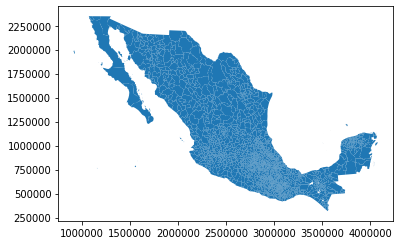

In [92]:
# We rename the columns in the shapefiles and drop the columns we don't need 
urban_shapes = urban_shapes.rename(columns={'CVEGEO':'clave_entidad'})
del urban_shapes['CVE_ENT']
del urban_shapes['CVE_MUN']

print("Shapefile: ",urban_shapes.shape)
urban_shapes.head(1)

# We merge the polygons of the entities with the complexity index for each entity
mexico = urban_shapes.merge(complexity, on='clave_entidad' , how='outer')

# There are a few municipalities for which we don't have the complexity index because they're new in the country
# we take those out, they're 7
mexico = mexico[~mexico.ECI.isnull()]
mexico.plot()


# Selección de focos atractores

In [12]:
# Desviación estándar de los datos de complejidad
sd = np.std(mexico.ECI.values.tolist())

# Le asignamos a cada municipio el número de municipios cuya complejidad cae a +/- 1/2 de desviación estándar 
# de su complejidad.

final = []
for i in range(len(mexico.ECI.values.tolist())):
    
    d = mexico.ECI.values.tolist()[i]
    m = mexico.cve_mun.values.tolist()[i]
    
    mas_sd = d + (sd/2)
    menos_sd = d - (sd/2)
   
    cluster = 0
    for j in mexico.ECI.values.tolist():
        if j > menos_sd and j < mas_sd:
            cluster = cluster +1
           
            
    a = (m,d, cluster)
    
    final.append(a)
   

df = pd.DataFrame(final)
df = df.rename(columns={1:'ECI',2:'normalidad',0:'cve_mun'})
df = df.sort_values(by='ECI', ascending=False)

# Normalizamos los datos de complejidad y "normalidad" para clusterizar
df['ECI_norm'] = (df['ECI'] -df['ECI'].min()) / (df['ECI'].max()- df['ECI'].min())
df['normalidad_norm'] = (df['normalidad'] - df['normalidad'].min()) / (df['normalidad'].max()-df['normalidad'].min())

#### Usamos los datos de complejidad y "normalidad" normalizados para clusterizar al país

0 0.08137712298001848 -0.6965709495248051 1225 1075 975
1 -1.0272365579618878 -1.5978965154273406 733 210 268
2 1.918771379685344 0.8545691658851691 432 107 185
3 0.8520429555302259 0.4038816303719983 796 437 280
4 -0.7040366843793635 -1.0250256565784388 1060 737 290
5 4.970805315908184 1.9503469059619007 101 2 137
6 0.3988377963903692 0.06857857349919393 1089 804 321


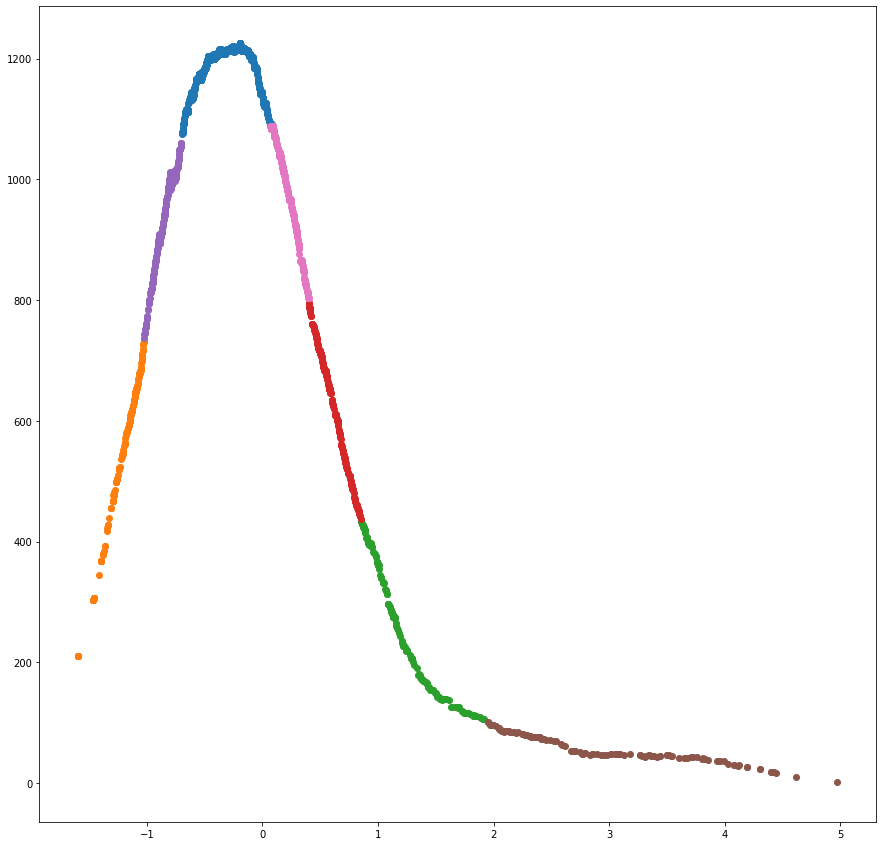

In [13]:
X = df[['ECI_norm','normalidad_norm']].values

# Dividimos al país en 7 clusters
kmeans = KMeans(n_clusters=7, random_state=0).fit(X)

df['cluster'] = kmeans.labels_.tolist()

plt.figure(figsize=(15,15))
for i in range(0,7):
    sub = df[df.cluster == i]
    
    plt.scatter(x=sub['ECI'], y=sub['normalidad'])
   
    print(i, sub['ECI'].max(), sub['ECI'].min(), sub['normalidad'].max(), sub['normalidad'].min(), sub.shape[0])
    

In [14]:
maximos = df[df.cluster == 5][['cve_mun']]

In [15]:
nombres = urban_shapes[['NOMGEO', 'cve_mun']]

In [16]:
maximos = maximos.merge(nombres, on='cve_mun', how='left')

In [20]:
maximos.to_csv('complejidad_alta.csv',index=False, encoding='latin')

In [21]:
maximos

,cve_mun,NOMGEO
0,14039,Guadalajara
1,09016,Miguel Hidalgo
2,19039,Monterrey
3,09015,CuauhtÃ©moc
4,24028,San Luis PotosÃ­
...,...,...
132,05025,Piedras Negras
133,07078,San CristÃ³bal de las Casas
134,21140,San Pedro Cholula
135,29005,Apizaco


In [24]:
#complejidad.tail(50).to_csv('municipios_menos_complejos.csv', index=False, )

# Proximidad con Aeroespacial

In [26]:
acts= [311511,541930,336410,711320,541820,561590,336340,339992,335920,
339991,327213,236212,623221,331220,311940,331210,335920,431193,711320,
541930,519110,333242,333412,331220,339113,334519,541370,339113,'6232CC',
541870,493120,336610,623221,312131]


In [27]:
for i in range(len(acts)):
    acts[i] = str(acts[i])

In [101]:
relate = pd.read_csv('/home/lorena/Documents/Economia/clusterizacion_y_complejidad/Data/Municipality/Produccion_bruta_sobre_empleo/relatedness_matrix_clave_actividad_economica_and_cve_mun_2014_A111A_H001A_6.csv')
print(relate.shape)
display(relate.head())

(1147, 2457)


,clave_actividad,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,32049,32050,32051,32052,32053,32054,32055,32056,32057,32058
0,112511,0.434944,0.012889,0.063791,0.009491,0.102039,0.046263,0.055028,0.010111,0.006558,...,0.043722,0.003341,0.019792,0.012107,0.010875,0.006700,0.034525,0.222051,0.010439,0.005545
1,112512,0.291849,0.082014,0.243075,0.067064,0.186278,0.207646,0.212072,0.054273,0.048151,...,0.197696,0.028021,0.092147,0.076257,0.073042,0.054473,0.168046,0.384929,0.071451,0.036805
2,11251C,0.341683,0.034531,0.126546,0.026999,0.122081,0.105711,0.109695,0.018703,0.019340,...,0.101938,0.009167,0.046084,0.029029,0.030483,0.017823,0.085953,0.305793,0.027772,0.014694
3,114111,0.432227,0.030536,0.118269,0.024967,0.141429,0.092992,0.101319,0.020179,0.017640,...,0.091136,0.009367,0.040144,0.029416,0.027934,0.018905,0.073402,0.328065,0.026780,0.016280
4,114112,0.199897,0.015770,0.088527,0.011630,0.086141,0.065352,0.065709,0.012169,0.008779,...,0.061265,0.002652,0.018069,0.014289,0.011145,0.007253,0.050401,0.224074,0.013367,0.003652


In [102]:
relate = relate[relate.clave_actividad.isin(acts)]

In [114]:
aero = []
peso = []
for mun in relate.set_index('clave_actividad').columns:
    print(mun)
    #m = 0
    for value in relate[mun].values:
        m=0
        if value > 0.2:
            m = m +1


    if m != 0:
        aero.append(str(mun).zfill(5))
        peso.append(m)
    #break

1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
2001
2002
2003
2004
2005
3001
3002
3003
3008
3009
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
6001
6002
6003
6004
6005
6006
6007
6008
6009
6010
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
8001
8002
8003


30004
30005
30006
30007
30008
30009
30010
30011
30012
30013
30014
30015
30016
30017
30018
30019
30020
30021
30022
30023
30024
30025
30026
30027
30028
30029
30030
30031
30032
30033
30034
30035
30036
30037
30038
30039
30040
30041
30042
30043
30044
30045
30046
30047
30048
30049
30050
30051
30052
30053
30054
30055
30056
30057
30058
30059
30060
30061
30062
30063
30064
30065
30066
30067
30068
30069
30070
30071
30072
30073
30074
30075
30076
30077
30078
30079
30080
30081
30082
30083
30084
30085
30086
30087
30088
30089
30090
30091
30092
30093
30094
30095
30096
30097
30098
30099
30100
30101
30102
30103
30104
30105
30106
30107
30108
30109
30110
30111
30112
30113
30114
30115
30116
30117
30118
30119
30120
30121
30122
30123
30124
30125
30126
30127
30128
30129
30130
30131
30132
30133
30134
30135
30136
30137
30138
30139
30140
30141
30142
30143
30144
30145
30146
30147
30148
30149
30150
30151
30152
30153
30154
30155
30156
30157
30158
30159
30160
30161
30162
30163
30164
30165
30166
30167
30168
30169
3017

In [119]:
data= pd.DataFrame({'clave_entidad':aero, 'peso':peso})
print(data.shape)

(67, 2)


In [124]:
data['peso'] = data['peso']  / data['peso'].max() + 1

In [127]:
data.max()

clave_entidad    31050.0
peso                 2.0
dtype: float64

In [137]:
urban_shapes_1 = urban_shapes.merge(data, on='clave_entidad', how='left')
urban_shapes_1.loc[urban_shapes_1.peso.isnull(),'peso'] = 0.5

In [129]:
urban_shapes_1['peso'] = (urban_shapes_1['peso'] - urban_shapes_1['peso'].min()) / (urban_shapes_1['peso'].max() - urban_shapes_1['peso'].min())

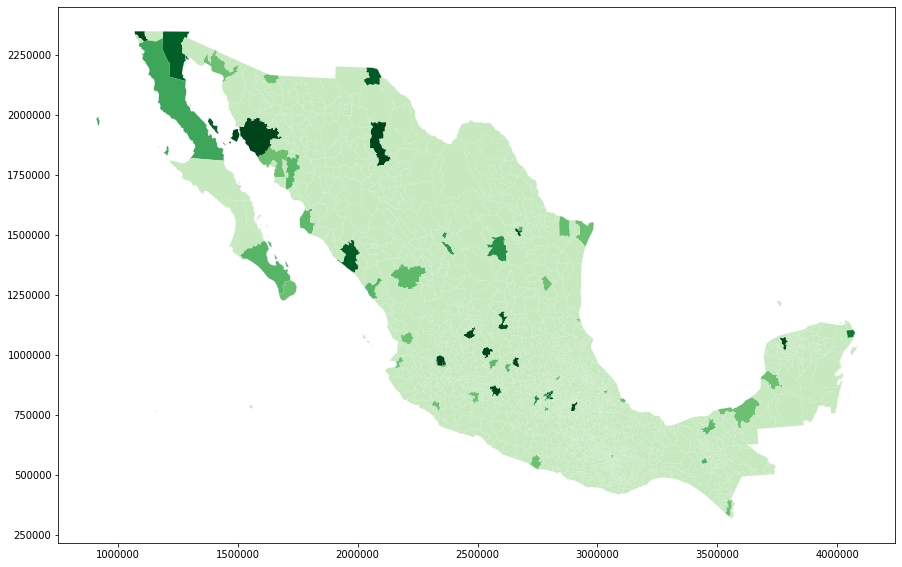

In [138]:
urban_shapes_1.plot(figsize=(15,15),column='peso', cmap = 'Greens', vmax=2, vmin=0)

In [145]:
x = urban_shapes_1[urban_shapes_1.peso != 0.5][['clave_entidad','NOMGEO','peso']]
x.to_csv('municipios_aeroespacial.csv',index=False, encoding='latin')